In [1]:
import os
import subprocess
from IPython.display import FileLink, display
import gc
import random
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

import pywt
from math import ceil
import scipy as sp
from scipy import signal
from scipy import fftpack
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

import json
from tqdm import tqdm
import glob
import re
from typing import Iterable
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
!pip install torcheval --no-index --find-links=file:///kaggle/input/torcheval/torcheval/
from torcheval.metrics import MulticlassAUPRC
from torcheval.metrics import BinaryAUPRC
#import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import GradScaler

from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, average_precision_score

import warnings
warnings.filterwarnings(action='ignore')

Looking in links: file:///kaggle/input/torcheval/torcheval/
Processing /kaggle/input/torcheval/torcheval/torcheval-0.0.6-py3-none-any.whl
Processing /kaggle/input/torcheval/torcheval/torchtnt-0.1.0-py3-none-any.whl (from torcheval)
Processing /kaggle/input/torcheval/torcheval/pyre_extensions-0.0.30-py3-none-any.whl (from torchtnt>=0.0.5->torcheval)


In [2]:
class Config:
    datasets_folder = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'
    step_data_folder = '/kaggle/input/private-steprate/features/'
    working_folder = '/kaggle/working/'
    tdcs_features_ds_folder = '/kaggle/input/tdcs-steps/kaggle/working/features/'
    data_names = ('tdcsfog', 'defog')
    #saved_features_file = '.csv'
    frequencies = (128, 100)
    g = 9.806

    batch_size = 1
    num_workers = 8
    
    feature_window_size = 128
    
    window_size = 512
    window_front = 96
    window_back = 96
    window_body = window_size - window_front - window_back
    #window_future = 8
    #window_past = window_size - window_future
    
    model_dropout = 0.1
    model_nlayers = 4
    model_middles = [16, 12, 8, 4]
    #model_nlayers = 5
    #model_middles = [16, 12, 12, 8, 4]
    model_nblocks = 4
    model_layers_grow = 0
    
    #lr = 0.00015
    lr = 0.00002
    num_epochs_per_turn = 20
    num_turns = 4
    eval_freq = 5
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    feature_list = ['acc_v', 'acc_ml', 'acc_ap']
    nfeatures = len(feature_list)
    label_list_full = ['start_hesitation', 'turn', 'walking']
    label_list = label_list_full
    #label_list = ['walking']
    #label_list = ['start_hesitation']
    #label_list = ['start_hesitation', 'walking']
    nlabels = len(label_list)
    
    load_model_from_file = False
    #model_file = '/kaggle/input/best-model-state-05/best_model_state_05.h5'
    model_file = '/kaggle/input/model-state-03/model_state_02.h5'
    
cfg = Config()
#cfg.lr = 0.00003
#cfg.model_dropout = 0.1
#cfg.num_epochs = 3

In [3]:
cfg.device

'cuda'

In [4]:
def make_layers( nl = cfg.model_nlayers, grow = cfg.model_layers_grow ):
    base = (cfg.window_front + cfg.window_back - grow * nl * (nl+1)//2)//nl
    layers_list = np.array([1 + base + (i+1)*grow for i in range(nl)])
    layers_list = layers_list + 1 - np.divmod(layers_list, 2)[1]
    layers_list[-1] = cfg.window_front + cfg.window_back + nl - sum(layers_list[0:-1])
    print('layers', layers_list)
    print('zero is correct', sum(layers_list)- nl - cfg.window_front - cfg.window_back)
    return layers_list
cfg.layers = make_layers()

layers [49 49 49 49]
zero is correct 0


In [5]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

def read_data_file(test_id, subfolder_name = 'train/tdcsfog/'):
    try:
        data = pd.read_csv(cfg.datasets_folder+subfolder_name + str(test_id) + '.csv')
    except:
        return pd.NA
    data.columns = [camel_to_snake(c) for c in data.columns]
    return data

def _find_binary(items: Iterable[int], item: int):
    min = 0
    max = len(items)-1
    if items[max]<=item:
        return max
    while min<max:
        split = (max+min)//2
        item_split = items[split]
        if item < item_split:
            max = split
        else:
            min = split+1
    return min

In [6]:
def detect_steps(signal, frequency=128, smoothing=2, faster_please=False, min_scale_log=3.6, max_scale_log=5.4):
    
    # scales for wavelets that define frequencies, exp for more even distribution
    # choosing border values is tricky
    # too narrow and we lose some slow or fast steprates
    # too wide and we get the steprate wrong for unusual walking wavelet spectrum cases
    # check patient #6 in the tdcsfog dataset as an example of an unusual pattern
    scales = np.exp(np.arange(min_scale_log, max_scale_log, 0.05))
    wavelet='morl'  # chosing the Morlet wavelet
    
    # transforming the signal, preferrably the 'AccMl' one
    coeff, freq = pywt.cwt(signal, scales, wavelet)
    # finding the brightest dots on every time slice
    coeff_argmax_index = np.argmax(abs(coeff), 0)
    # and collecting their coeff values in a new "signal", which already looks like our step rate, but is a bit noisy
    coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])
    
    # repeating the smoothing procedure
    for i in range(smoothing):
        # transforming the noisy step rate again to clear it
        coeff, freq = pywt.cwt(coeff_max, scales, wavelet)
        # finding the brightest dots on every time slice
        coeff_argmax_index = np.argmax(abs(coeff), 0).astype(int)
        # and smoothing their indices with median to cut some outbursts off
        coeff_argmax_index = np.round(pd.Series(coeff_argmax_index).rolling(128, center=True, min_periods=1).median()).astype(int)
        # collecting the values along our line of indices
        coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])
    
    # this smoothing round is optional
    if not faster_please:
        # finding hopefully bigger peaks on our line
        # hopefully skiping too narrow or too close ones that are likely to be outbursts
        max_cwt_points = sp.signal.find_peaks(abs(coeff_max), distance=20, width=20)[0]
        max_cwt_points = np.concatenate(([0], max_cwt_points, [len(signal)-1]))
        # and interpolating our line in wavelet space between the bigger peaks
        max_cwt_line_indexes = np.round(np.interp( range(0, len(signal)), max_cwt_points, 
                                                    coeff_argmax_index[max_cwt_points])).astype(int)
        coeff_max = np.array([coeff[max_cwt_line_indexes[i], i] for i in range(coeff.shape[1])])
    
    # finding zeroes on this smooth line to separate individual steps from other steps    
    zero_crossings = np.where( np.diff(np.sign(pd.Series(coeff_max).rolling(10, center=True, min_periods=1).mean())))[0]
    zero_crossings = np.concatenate( ([0], zero_crossings, [len(signal)]))    
    #filling each step with its duration while cutting possible outbursts with median
    step_lengths = []
    for i in range(1, len(zero_crossings)):
        step_lengths = np.concatenate( (step_lengths, [zero_crossings[i] - zero_crossings[i-1]]*(zero_crossings[i] - zero_crossings[i-1]) ))
    step_durations = pd.Series(step_lengths).rolling(32, center=True, min_periods=1).median()
    # making a nice and smooth step_rate array
    step_rate = pd.Series( 1./step_durations )*frequency
    step_rate = step_rate.where(step_rate<5, 0).rolling(frequency, center=True, min_periods=1).mean()
    
    return step_rate, step_durations/frequency, zero_crossings

In [7]:
%%time
#folder_path_tdcs = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'
# folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
#all_files_tdcs = [file for file in os.listdir(folder_path_tdcs)]
# all_files_defog = [file for file in os.listdir(folder_path_defog)]

#df_tdcsfog = pd.DataFrame(all_files_tdcs, columns = ['id'])
#df_tdcsfog['id'] = df_tdcsfog['id'].apply(lambda x: x.rsplit('.',1)[0])
#df_tdcsfog['data'] = df_tdcsfog['id'].apply(read_data_file)

#df_tdcsfog['fog'] = df_tdcsfog['data'].apply(lambda x: x[['walking', 'start_hesitation']].max().max())
#train_ids, valid_ids = train_test_split(df_tdcsfog['id'], random_state=42, stratify = df_tdcsfog['fog'])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [8]:
#os.mkdir('/features/')
#os.mkdir('/features/zero_crossings/')

In [9]:
a = np.random.rand(10)
a

array([0.92299645, 0.95396182, 0.71169549, 0.97085298, 0.81604976,
       0.69060945, 0.14292169, 0.84169352, 0.23105536, 0.12281617])

In [10]:
a = np.random.rand(10)
b = range(10)
f = CubicSpline(b,a)

In [11]:
cfg.working_folder = '/kaggle/working/'
def make_feature_file(data_row):
    #data = data_row['data']
    step_rate, step_durations, zero_crossings = detect_steps(data_row['data']['acc_ml'])
    data_row['data']['step_rate'] = step_rate
    data_row['data']['step_durations'] = step_durations
    data_row['data'].to_csv(cfg.working_folder + 'features/'+data_row['id']+'.csv')
    pd.DataFrame(zero_crossings).to_csv(cfg.working_folder + 'features/zero_crossings/'+data_row['id']+'.csv')
    

#def make_feature_files(dataset):
#    for data_row in tqdm(dataset):
#        data = data_row['data']
#        step_rate, step_durations, zero_crossings = detect_steps(data['acc_ml'])
#        data_row['data']['steprate'] = step_rate
#        data_row['data']['step_durations'] = step_durations
#        data_row['data']['zero_crossings'] = zero_crossings
#        data_row['data'].to_csv('features/'+data_row['id']+'.csv')

In [12]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [13]:
def download_model(model_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{model_name}.zip"
    command = f"zip {zip_name} {model_name}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{model_name}.zip'))

In [14]:
#download_file('/kaggle/working/features/', 'features.zip')
download_model('model_state_02.h5')
#download_file('/kaggle/working/features/', 'features.zip')

/kaggle/working/model_state_02.h5.zip

In [15]:
#%%time
#make_feature_files(df_tdcsfog)
#try:
#    os.mkdir(cfg.working_folder + 'features/')
#    os.mkdir(cfg.working_folder + 'features/zero_crossings/')
#except: 
#    pass

#df_tdcsfog.apply(make_feature_file, axis=1)

In [16]:
cfg.wavelet_scales = np.exp(np.arange(2, 6, 0.5))
cfg.wavelet_list = [ f'wave_{scale}' for scale in cfg.wavelet_scales ] 
cfg.wavelet='morl'
#wavelet='shan'

def make_features_train(data, defog=False):
    mean_center = True
    if not defog:
        data[['acc_v', 'acc_ap','acc_ml']] /= 9.806
    rolling_window_size = cfg.feature_window_size
    data['acc_ml_abs_rolling_mean'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_ml_abs_rolling_min'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['acc_ml_abs_rolling_max'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).max()
    data['acc_apv'] = (data['acc_ap']**2 + data['acc_v']**2)**0.5 - 1
    data['acc_apv_rolling_mean'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_apv_rolling_delta'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).max() -\
        abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['angle'] = data['acc_ap'] / data['acc_v'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['angle_rolling_mean'] = data['angle'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_v'] = data['acc_v']/3
    data['defog'] = 1 if defog else -1
    
    coeff, freq = pywt.cwt(data['acc_ml'], cfg.wavelet_scales, cfg.wavelet)
    for i, scale in enumerate(cfg.wavelet_scales):
        data[f'wave_{scale}'] = coeff[i] 
    
    coeff_argmax = pd.Series(freq[np.argmax(abs(coeff), 0)]*cfg.frequencies[0])\
        .rolling(50, center=mean_center, min_periods=1).median().rolling(50, center=mean_center, min_periods=1).max()
    data['coeff_argmax'] = coeff_argmax
    
    return data


def make_features(data, defog = False): 
    if defog:
        step_rate, step_durations, zero_crossings = detect_steps(data['acc_ml'], frequency=128, min_scale_log=3.35, max_scale_log=5.2)
    else:
        step_rate, step_durations, zero_crossings = detect_steps(data['acc_ml'])
    data['step_rate'] = step_rate
    data['step_durations'] = step_durations
    
    if defog:
        new_values = rescale_freq_2(data.values, old_freq = 100, new_freq = 128)
        new_data = pd.DataFrame(new_values, columns = data.columns)
        data = new_data
    
    data = make_features_train(data, defog=defog)
    return data
    

def make_features_row(data_row, df_name):
    data = data_row['data']
    mean_center = True
    rolling_window_size = rolling_window_size = cfg.feature_window_size
    data['acc_ml_abs_rolling_mean'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_ml_abs_rolling_min'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['acc_ml_abs_rolling_max'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).max()
    #data['steprate'] = abs(data['acc_ml']).rolling(128, center=True, min_periods=1).max()
    data['acc_apv'] = (data['acc_ap']**2 + data['acc_v']**2)**0.5 - 9.806
    data['acc_apv_rolling_mean'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_apv_rolling_delta'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).max() -\
        abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['angle'] = data['acc_ap'] / data['acc_v'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['angle_rolling_mean'] = data['angle'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_v'] = data['acc_v']/3
    #data['acc_ap'] = data['acc_ap']
    tmp_df = pd.read_csv(cfg.tdcs_features_ds_folder + data_row['id'] + '.csv')
    data = data.join(tmp_df[['steprate', 'step_durations']])
    
    scales = np.exp(np.arange(2, 6, 0.5))
    wavelet='morl'
    #wavelet='shan'
    coeff, freq = pywt.cwt(data['acc_ml'], scales, wavelet)
    cfg.wavelet_list = []
    for i, scale in enumerate(scales):
        data[f'wave_{scales}'] = coeff[i]
        cfg.wavelet_list.append(f'wave_{scales}')
    coeff_argmax = pd.Series(freq[np.argmax(abs(coeff), 0)]*cfg.frequencies[0])\
        .rolling(50, center=mean_center, min_periods=1).median().rolling(50, center=mean_center, min_periods=1).max()
    data['coeff_argmax'] = coeff_argmax
    
    return data

In [17]:
%%time
#df_tdcsfog['data'] = df_tdcsfog.apply(make_features_row, axis=1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.39 µs


In [18]:
cfg.feature_list = [
    #'acc_v',           doesn't help
    'acc_ml', 
    #'acc_ap',
    'acc_ml_abs_rolling_mean',
    'acc_ml_abs_rolling_min',
    'acc_ml_abs_rolling_max',
    'acc_apv',
    'acc_apv_rolling_mean',
    'acc_apv_rolling_delta',
    'defog',
    #'angle',
    'angle_rolling_mean',
    'step_rate',
    'defog'
 #   'step_durations', doesn't help - maybe they were just too big
 #   'coeff_argmax'    doesn't help
] + cfg.wavelet_list

cfg.nfeatures = len(cfg.feature_list)

In [19]:
def len_rescale(length, old_freq = 100, new_freq = 128):
    old_dt, new_dt = 1.0/old_freq, 1.0/new_freq
    return len( np.arange(0, len(data_array)*old_dt, new_dt) )

def len_rescale_de(length):
    return en_rescale(length, old_freq = 128, new_freq = 100)

def rescale_freq(data_array, old_freq = 100, new_freq = 128):
    old_dt, new_dt = 1.0/old_freq, 1.0/new_freq
    time_old = np.arange(0, len(data_array)*old_dt, old_dt)
    time_new = np.arange(0, len(data_array)*old_dt, new_dt)
    f = CubicSpline(time_old, data_array)
    return np.array([f(t) for t in time_new])

def rescale_freq_2(data_array, old_freq = 100, new_freq = 128):
    old_dt, new_dt = 1.0/old_freq, 1.0/new_freq
    max_time = len(data_array)*old_dt - old_dt
    time_old = np.linspace(0, max_time,len(data_array))
    time_new = np.linspace(0, max_time,round(len(data_array)*new_freq/old_freq))
    #print( len(time_old), data_array.shape )
    f = interp1d(time_old, data_array, axis=0, kind = 'linear')
    return f(time_new) #time_new.apply(f) #[f(t) for t in time_new]

def rescale_freq_de(data_array):
    return rescale_freq_2(data_array, old_freq = 128, new_freq = 100)

def plus_minus_from_t(t):
    diff = np.diff(t,1)
    plus = np.where(diff==1)[0]
    minus = np.where(diff==-1)[0]
    if t[0]==1:
        plus = np.concatenate( ([-1], plus))
    if t[-1]==1:
        minus = np.concatenate( (minus, [len(t)-1]))
    return plus+1, minus+1

In [20]:
class cDataHolder():
    def __init__(self):
        return
    
    def make_fog_class(self, row, defog_split=5000, tdcs_split=2000):
        if ( not row['tdcs'] ) and ( row[['fog_start_hesitation', 'fog_walking', 'fog_turn']].sum()>defog_split ):
            fog_class = 'defog_yes'
        elif ( not row['tdcs'] ): 
            fog_class = 'defog_no'
        elif ( row['fog_walking'] == 0 ) and ( row['fog_start_hesitation'] == 0 ):
            fog_class = 'fog_no_complex'
        elif ( row['fog_walking'] == 0 ) and ( row['fog_start_hesitation'] < tdcs_split ):
            fog_class = 'fog_some_hesitation'
        elif ( row['fog_walking'] < tdcs_split) and ( row['fog_start_hesitation'] == 0 ):
            fog_class = 'fog_some_walking'
        elif ( row['fog_walking'] >= tdcs_split):
            fog_class = 'fog_bad_walking'
        elif ( row['fog_start_hesitation'] >= tdcs_split ):
            fog_class = 'fog_bad_hesitation'
        else:
            fog_class = 'fog_some_complex'
        return fog_class
    
   # def load_steps(self, data_id, ds_name):
   #     ds_name = ds_name + '/'
   #     file_df = pd.read_csv(cfg.datasets_folder + 'train/' + ds_name + data_id +'.csv')
   #     file_df.columns = [camel_to_snake(c) for c in file_df.columns]
   #     steps_df = pd.read_csv(cfg.step_data_folder + ds_name + data_id +'.csv')
   #     file_df = file_df.join(steps_df)
   #     return file_df
    
    def make_defog_task_list(self, file_number):
        a = self.list_t[file_number]
        diff = np.diff(a,1)
        plus = np.where(diff==1)[0]
        minus = np.where(diff==-1)[0]
        return np.vstack( (plus+1, minus+1) )
    
    def process_defog_file(self, file_data, just_task=False):
        t_big = (file_data['task']*file_data['valid']).values.astype(int)
        if just_task:
            t_big = (file_data['task']).values.astype(int)          
        diff = np.diff(t_big,1)
        plus = np.where(diff==1)[0]
        minus = np.where(diff==-1)[0]
        count = len(plus)
        x = np.zeros( [(minus-plus).sum() + 2*cfg.window_front*(count), cfg.nfeatures] )
        y = np.zeros( ((minus-plus).sum() + 2*cfg.window_front*(count - 1)) )
        y3 = np.zeros( ((minus-plus).sum() + 2*cfg.window_front*(count - 1), 3) )
        t = np.zeros( ((minus-plus).sum() + 2*cfg.window_front*(count - 1)) )
        #print( len(t_big), (minus-plus).sum() , len(plus))
        
        index0, index1 = 0, 0
        sum_ws = 0
        for first, count in zip (plus, minus-plus):
            #print(first, count, first+count)
            wsize = count + 2*cfg.window_front
            sum_ws += wsize
            index0 = first - cfg.window_front
            
            index_fix = index0 if index0>=0 else 0
            index_last_fix = index0 + wsize if index0 + wsize< len(file_data) else len(file_data)
            length_fix = index0 - index_fix + index_last_fix - index0 - wsize
            
            features = file_data[cfg.feature_list]
            if index1 < 0:
                x[ 0 : index1 + wsize] = features.values[ index0 + index1: index0 + wsize ]
                print('shit')
            elif index0 + wsize>features.values.shape[0]:
                print('fuck')
                x[ index1 : index1 + features.values.shape[0].shape[0] - index0] = features.values[ index0: features.values.shape[0].shape[0] ]
            else:
                x[ index1 : index1 + wsize] = features.values[ index0: index0 + wsize ]
                        
            targets = file_data[cfg.label_list].values
            targets = np.concatenate([targets, (1 - targets.sum(axis=1)).reshape(-1,1)], axis=1)
            y[ index1: index1 + count] = np.argmax(targets, axis=1)[ 
                        index0 + cfg.window_front : index0 + count + cfg.window_front ]
            y3[ index1: index1 + count] = file_data[cfg.label_list].values[ 
                        index0 + cfg.window_front : index0 + count + cfg.window_front ]
            t[ index1 : index1 + count] = 1
            index1 += wsize

        return x, y, y3, t
    
    def prepare_data_row(self, data_id, ds_name):
        ds_name = ds_name + '/'
        file_df = pd.read_csv(cfg.datasets_folder + 'train/' + ds_name + data_id +'.csv')
        file_df.columns = [camel_to_snake(c) for c in file_df.columns]
        steps_df = pd.read_csv(cfg.step_data_folder + ds_name + data_id +'.csv')
        file_df = file_df.join(steps_df)
        
        # ----------------- rescale time here
        if ds_name == 'defog/':
            new_df = pd.DataFrame()
            time_old = np.arange(0, len(file_df)/100, 0.01)

            new_df = pd.DataFrame( np.vstack( rescale_freq_2(file_df.values) ) )
            new_df.columns = file_df.columns
            file_df = new_df
            file_df = make_features_train(file_df)
            x, y, y3, t = self.process_defog_file(file_df)
#            self.list_t.append( np.vstack( ((file_df['task']*file_df['valid']).values.astype(int),
#                                                file_df['task'].astype(int).values,
#                                                file_df['valid'].values.astype(int)) ) )
            self.list_t.append(t)
        else:
            #self.list_t.append( np.ones( (3, len(file_df)) ) )            
            self.list_t.append( np.ones( len(file_df) ) )
            file_df = make_features_train(file_df)
            x = file_df[cfg.feature_list].values
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
            targets = file_df[cfg.label_list].values
            y = np.concatenate([targets, (1 - targets.sum(axis=1)).reshape(-1,1)], axis=1)
            y = np.argmax(y, axis=1)
            y3 = targets
            #print(len(file_df), y.shape, y3.shape, x.shape)
            
                
        self.list_x.append(x)     
        self.list_y.append(y)
        self.list_y3.append(y3)        
        return len(self.list_x)-1
    
    def load_train_data(self, load_tdcs = True, load_defog = True):
        self.list_x, self.list_y, self.list_t, self.list_y3, self.task_list = [], [], [], [], []
        if load_tdcs:
            folder_path_tdcs = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'
            all_files_tdcs = [file for file in os.listdir(folder_path_tdcs)]
            self.df_tdcs = pd.DataFrame(all_files_tdcs, columns = ['id'])
            self.df_tdcs['id'] = self.df_tdcs['id'].apply(lambda x: x.rsplit('.',1)[0])

            for index, row in tqdm(self.df_tdcs.iterrows()):
                self.prepare_data_row(row['id'], 'tdcsfog') 
                self.task_list.append([0, dataholder.list_x[index].shape[0]])

            self.df_tdcs['tdcs'] = True
            self.df = self.df_tdcs.copy()
        
        if load_defog:
            folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
            all_files_defog = [file for file in os.listdir(folder_path_defog)]
            #all_files_defog = all_files_defog[:10]  #------------------------------------------------------ DEBUG!!
            self.df_defog = pd.DataFrame(all_files_defog, columns = ['id'])
            self.df_defog['id'] = self.df_defog['id'].apply(lambda x: x.rsplit('.',1)[0])

            for index, row in tqdm(self.df_defog.iterrows()):
                self.prepare_data_row(row['id'], 'defog')
                self.task_list.append( self.make_defog_task_list(index) )

            self.df_defog['tdcs'] = False
            if load_tdcs:
                print(len(self.df), len(self.df_tdcs), len(self.df_defog))
                self.df = self.df.append(self.df_defog).reset_index(drop=True)
                print(len(self.df))
            else:
                self.df = self.df_defog
                
        for index, label in enumerate(cfg.label_list):
            dataholder.df['fog_'+label] = dataholder.df.reset_index()['index'].apply( lambda x: dataholder.list_y3[x][:,index].sum())
        self.df['fog_class'] = self.df.apply(self.make_fog_class, axis=1)
        
    #def reorganize_defog()
    
    def make_a_train_valid_combo(self, test_size=0.2, complex_mult=3, train_tdcs=True, train_defog=True, stratify=True, val_tdcs=True, val_defog=True):
        all_nums = self.df.index
        if stratify:   
            train_nums, valid_nums = train_test_split(self.df.index, test_size=test_size, stratify = self.df['fog_class'])
        else:
            train_nums, valid_nums = train_test_split(self.df.index)
        if not train_tdcs:
            train_nums = self.df.loc[train_nums][~self.df['tdcs']].index
        if not val_defog:
            train_nums = self.df.loc[train_nums][self.df['tdcs']].index
        if not val_tdcs:
            valid_nums = self.df.loc[valid_nums][~self.df['tdcs']].index
        if not val_defog:
            valid_nums = self.df.loc[valid_nums][self.df['tdcs']].index
            
        df_train = self.df.loc[train_nums]['fog_class']
        df_complex = df_train[ (df_train!='fog_no_complex') & (df_train!='defog_no') ]
        df_fog = df_train[ (df_train=='fog_no_complex') | (df_train=='defog_no') ]
        #print(len(df_fog), len(df_complex))
        for i in range(complex_mult):
            df_fog = df_fog.append(df_complex)            
        train_nums = df_fog.sample(frac=1).index
        return train_nums, valid_nums
            
        
    def prepare_train_valid(self, complex_mult=3):    
        self.train_nums, self.valid_nums = train_test_split(self.df.index, stratify = self.df['fog_class'])
        df_train = self.df.loc[self.train_nums]['fog_class']
        df_complex = df_train[ (df_train!='fog_no_complex') & (df_train!='defog_no') ]
        df_fog = df_train[ (df_train=='fog_no_complex') | (df_train=='defog_no') ]
        #print(len(df_fog), len(df_complex))
        for i in range(complex_mult):
            df_fog = df_fog.append(df_complex)            
        self.train_nums = df_fog.sample(frac=1).index
        
        df_train = self.df.loc[self.df[self.df['tdcs']].index] ['fog_class']
        df_complex = df_train[df_train!='fog_no_complex']
        df_fog = df_train[df_train=='fog_no_complex']
        #print(len(df_fog), len(df_complex))
        for i in range(10):
            df_fog = df_fog.append(df_complex)            
        self.full_tdcs_batch = df_fog.sample(frac=1).index
    
    
    def get_data(self, index, add_zeros = False):
        x = self.list_x[index]
        y = self.list_y[index]
        t = self.list_t[index]
        #t = self.task_list[index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
            
        x = torch.tensor(x).to(torch.float32)
        y = torch.Tensor(y).to(torch.int64)
        t = torch.Tensor(t).to(torch.int64)
        return x, y, t
        
    def __getitem__(self, index, is_train, add_zeros = False):
        file_index = self.train_nums[index] if is_train else self.valid_nums[index]
        return self.get_data(file_index, add_zeros)
    
    def get_file_batch(self, file_index, add_zeros = False, want_valid = False, want_fog = False, want_ugly = False, want_defog=False):
        if want_defog and want_ugly:
            file_index = self.df.loc[self.valid_nums].query('fog_start_hesitation*for_walking>0 and tdcs').index[file_index]
        elif want_defog:
            file_index = self.df.loc[self.valid_nums].query('tdcs').index[file_index]
        if want_ugly:
            file_index = self.df.loc[self.valid_nums].query('fog_start_hesitation*fog_walking>0').index[file_index]
        elif want_fog:
            file_index = self.df.loc[self.valid_nums].query('fog_start_hesitation+fog_walking+fog_turn>0').index[file_index]
        elif want_valid:
            file_index = self.df.loc[self.valid_nums].index[file_index]
        return  self.get_data(file_index, add_zeros)
    
    def get_file_batch_id(self, file_id, add_zeros = False):
        file_index = self.df[ self.df['id']==file_id ].index[0]
        return self.get_data(file_index)
    
    def make_file_batch(self, file_data, add_zeros = False, with_targets=False):
        x = file_data[cfg.feature_list].values
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        return x
    
dataholder = cDataHolder()

In [21]:
folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
all_files_defog = [file for file in os.listdir(folder_path_defog)]
defog_file = pd.read_csv(folder_path_defog + all_files_defog[0])
defog_file.columns = [camel_to_snake(c) for c in defog_file.columns]
defog_file = make_features(defog_file, defog=True)
x, y, y3, t = dataholder.process_defog_file(defog_file)
#defog_file

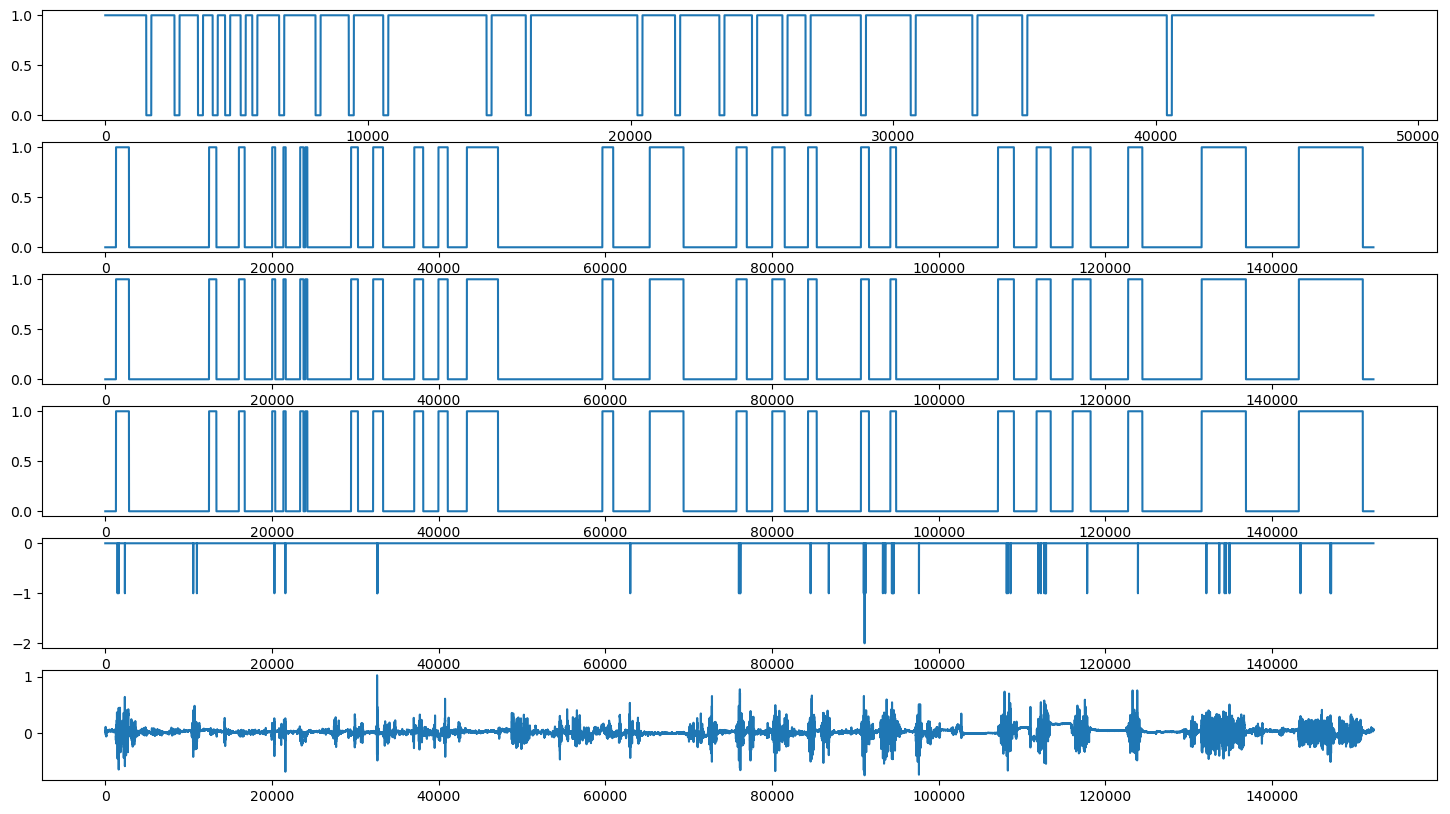

In [22]:
figs, axs = plt.subplots( 6,1, figsize=(18,10))
axs[0].plot(t)
t_big = (defog_file['task']*defog_file['valid']).values.astype(int)
axs[1].plot(t_big)
axs[2].plot((defog_file['task']).values.astype(int))
axs[3].plot((defog_file['valid']).values.astype(int))
axs[4].plot((defog_file[['acc_ap','acc_v','acc_ml']].sum(axis=1)).values.astype(int))
axs[5].plot((defog_file['acc_ml'].values))
#axs[2].plot(defog_file[cfg.feature_list[0]].values[:20000])

In [23]:
len(t)

48287

In [24]:
tmp = defog_file[cfg.feature_list]
tmp[:3].shape

(3, 19)

In [25]:
folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
all_files_defog = [file for file in os.listdir(folder_path_defog)]
df_defog = pd.DataFrame(all_files_defog, columns = ['id'])
tmp_defog = pd.read_csv(folder_path_defog+df_defog.loc[0,'id'])
tmp_defog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.002697,0.022371,0.068304,0,0,0,False,False
1,1,-1.002641,0.019173,0.066162,0,0,0,False,False
2,2,-0.999820,0.019142,0.067536,0,0,0,False,False
3,3,-0.998023,0.018378,0.068409,0,0,0,False,False
4,4,-0.998359,0.016726,0.066448,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
118865,118865,-1.001893,0.053704,-0.006347,0,0,0,False,False
118866,118866,-1.005036,0.051916,-0.008076,0,0,0,False,False
118867,118867,-1.005337,0.052860,-0.009193,0,0,0,False,False
118868,118868,-1.003345,0.057860,-0.007546,0,0,0,False,False


In [26]:
dataholder.load_train_data(load_tdcs=True, load_defog=True)

833it [01:02, 13.32it/s]
91it [03:35,  2.37s/it]

833 833 91
924


In [27]:

#tmplist = []
#for i in range(91):
#    tmplist.append()
dataholder.task_list[0]

[0, 7592]

In [28]:
dataholder.df

,id,tdcs,fog_start_hesitation,fog_turn,fog_walking,fog_class
0,a171e61840,True,0.000000,2821.000000,0.000000,fog_no_complex
1,4171ea3a0c,True,0.000000,0.000000,0.000000,fog_no_complex
2,0f985a8440,True,0.000000,0.000000,0.000000,fog_no_complex
3,5d320ade20,True,0.000000,379.000000,0.000000,fog_no_complex
4,ae8c67086b,True,0.000000,5901.000000,0.000000,fog_no_complex
...,...,...,...,...,...,...
919,f9fc61ce85,False,0.000000,541.344630,418.464332,defog_no
920,afc4b9d2a8,False,0.000000,10708.624233,0.000000,defog_yes
921,1d99c2eecf,False,76.843774,409.468879,133.093792,defog_no
922,0d7ab3a9f9,False,112.647964,18059.805186,0.000000,defog_yes


In [29]:
dataholder.df['fog_class'].value_counts()
#dataholder.df[~dataholder.df['tdcs']].value_counts()

fog_no_complex         706
defog_no                47
fog_some_hesitation     46
defog_yes               44
fog_some_walking        30
fog_bad_walking         18
fog_some_complex        17
fog_bad_hesitation      16
Name: fog_class, dtype: int64

In [30]:
dataholder.prepare_train_valid(complex_mult=1)
#dataholder.train_nums = dataholder.full_tdcs_batch
#gc.collect()

In [31]:
valid_data = dataholder.df.loc[dataholder.valid_nums]
valid_data

,id,tdcs,fog_start_hesitation,fog_turn,fog_walking,fog_class
23,685a08f19d,True,0.0,885.000000,0.000000,fog_no_complex
207,1e5f843874,True,0.0,3932.000000,0.000000,fog_no_complex
724,441362cade,True,0.0,7286.000000,2130.000000,fog_bad_walking
214,83ce03ef33,True,0.0,860.000000,0.000000,fog_no_complex
877,4ec23c3d98,False,0.0,3139.847145,33818.673358,defog_yes
...,...,...,...,...,...,...
729,f9fb303d4e,True,0.0,2619.000000,0.000000,fog_no_complex
347,e2b8e7b507,True,0.0,1555.000000,246.000000,fog_some_walking
422,b2bdaa64b9,True,0.0,0.000000,0.000000,fog_no_complex
14,0ee65f094c,True,0.0,0.000000,0.000000,fog_no_complex


In [32]:
#tmp = dataholder.get_file_batch(0, add_zeros = False, want_valid = False, want_fog = False, want_ugly = False, want_defog=True)

In [33]:
#full_tdcs_batch
#len(dataholder.full_tdcs_batch)
#df_train = dataholder.df.loc[dataholder.df[dataholder.df['tdcs']].index] ['fog_class']
#len(df_train)

In [34]:
class cFOGDataset_for_dataholder(Dataset):
    def __init__(self, is_train=True, split="train"):
        self.is_train = is_train
        self.split = split
        return
    def __len__(self):
        return len(dataholder.train_nums) if self.is_train else len(dataholder.valid_nums)
    def __getitem__(self, index, add_zeros = False):
        return( dataholder.__getitem__(index, self.is_train, add_zeros) )
    
class cFOGDataset_for_dataholder_premade_split(Dataset):
    def __init__(self, file_ids):
        self.file_ids = file_ids
        return
    def __len__(self):
        return len(self.file_ids)
    def __getitem__(self, index):
        return( dataholder.get_data(self.file_ids[index]) )
    
ds_train = cFOGDataset_for_dataholder(is_train=True, split = 'train')
ds_valid = cFOGDataset_for_dataholder(is_train=False, split = 'valid')
ds_full = cFOGDataset_for_dataholder(is_train=True, split = 'full')

In [35]:
train = dataholder.df.loc[dataholder.train_nums][~dataholder.df['tdcs']]
dataholder.df.loc[train.index]
#dataholder.train_nums.min()
#dataholder.df.index

,id,tdcs,fog_start_hesitation,fog_turn,fog_walking,fog_class
833,be9d33541d,False,0.000000,6092.786452,102.511827,defog_yes
844,8282009100,False,98.656501,18066.845315,2085.051178,defog_yes
887,6c300fcdd5,False,0.000000,705.183279,0.000000,defog_no
858,afaec39b8c,False,0.000000,342.813426,153.687917,defog_no
904,1ff78d55e9,False,0.000000,29358.788056,358.485203,defog_yes
...,...,...,...,...,...,...
881,2c12284ed2,False,0.000000,24783.504635,0.000000,defog_yes
884,54c6a21be6,False,0.000000,97.219037,0.000000,defog_no
874,a2f1a8ab76,False,0.000000,0.000000,39392.471852,defog_yes
913,f40e8c6ebe,False,0.000000,3439.347720,2553.494450,defog_yes


In [38]:
#complex_mult=3, train_tdcs=True, train_defog=True, stratify=True, val_tdcs=True, val_defog=True):
complex_mult=7
defog_train, defog_valid = dataholder.make_a_train_valid_combo(complex_mult=complex_mult, train_tdcs=False, val_tdcs=False)
tdcs_train, tdcs_valid = dataholder.make_a_train_valid_combo(complex_mult=complex_mult, train_defog=False, val_defog=False)
#both_train, both_valid = dataholder.make_a_train_valid_combo(complex_mult=complex_mult)
both_train = np.concatenate((tdcs_train, defog_train))
both_valid = np.concatenate((tdcs_valid, defog_valid))

print( len(defog_train), len(defog_valid))
print( len(tdcs_train), len(tdcs_valid))
print( len(both_train), len(both_valid))

282 19
1279 166
1561 185


In [39]:
ds_defog_train = cFOGDataset_for_dataholder_premade_split(defog_train)
ds_defog_valid = cFOGDataset_for_dataholder_premade_split(defog_valid)
ds_tdcs_train = cFOGDataset_for_dataholder_premade_split(tdcs_train)
ds_tdcs_valid = cFOGDataset_for_dataholder_premade_split(tdcs_valid)
ds_both_train = cFOGDataset_for_dataholder_premade_split(both_train)
ds_both_valid = cFOGDataset_for_dataholder_premade_split(both_valid)


In [40]:
class cFOGDataset_06(Dataset):
    def __init__(self, init_data, is_train=True, split="train"):
        self.df = init_data.loc[:, init_data.columns != 'data']
        self.df['t_count'] = init_data['data'].apply(lambda x: x['time'].count())
        self.df['window_count'] = np.ceil(self.df['t_count'] / cfg.window_body ).astype(int)
        self.df['window_sum'] = self.df['window_count'].cumsum()
        self.df['window_extra'] = self.df['window_count']*cfg.window_body - self.df['t_count']
        self.is_train = is_train
        self.split = split
        self.list_x, self.list_y = [], []
        for i in range(len(init_data)):
            self.list_x.append(init_data.loc[i, 'data'][cfg.feature_list].values)
            if is_train:
                targets = init_data.loc[i, 'data'][cfg.label_list].values
                self.list_y.append( np.concatenate([targets, (1 - targets.sum(axis=1)).reshape(-1,1)], axis=1) )  
        
    def __len__from_05(self):
        return self.df['window_count'].sum()
    
    def __len__(self):
        return self.df['window_count'].count()
    
    def get_index_y(self, index):
        file_index = _find_binary(self.df['window_sum'], index)
        infile_index = index if file_index==0 else index - self.df['window_sum'][file_index-1]
        time_index = infile_index * cfg.window_body
        return file_index, infile_index, time_index
    
    def get_file_batch(self, file_index, add_zeros = True):
        x = self.list_x[file_index]
        y = self.list_y[file_index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64).view(1, -1)
        return x, y, self.df.loc[file_index, 'id']
    
    def get_file_batch_id(self, file_id, add_zeros = True):
        file_index = self.df[ self.df['id']==file_id ].index[0]
        x = self.list_x[file_index]
        y = self.list_y[file_index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64).view(1, -1)
        return x, y
    
    def make_file_batch(self, file_data, add_zeros = True, with_targets=False):
        x = file_data[cfg.feature_list].values
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        return x
    
    def __getitem__(self, index, verbose = False, add_zeros = True):
        x = self.list_x[index]
        y = self.list_y[index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32)#.view(1, -1, cfg.nfeatures)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64)#.view(-1, 1)
        return x, y
    
    def __getitem__from_05(self, index, verbose = False, add_zeros = True):
        file_index = _find_binary(self.df['window_sum'], index)
        infile_index = index if file_index==0 else index - self.df['window_sum'][file_index-1]
        #time_index = infile_index * cfg.window_body - cfg.window_front
        time_index = infile_index * cfg.window_body
        x_index = time_index - cfg.window_front
        front_zeros = 0
        if x_index < 0:
            front_zeros = -x_index
            x_index = 0
        
        x = self.list_x[file_index][ x_index : x_index + cfg.window_size - front_zeros ]
        y = self.list_y[file_index][ time_index : time_index + cfg.window_body ]
        
        rear_zeros = cfg.window_size - x.shape[0] - front_zeros
        
        if front_zeros or rear_zeros:
            if add_zeros and front_zeros:
                x = np.concatenate((np.zeros((front_zeros, x.shape[1])), x))
            if add_zeros and rear_zeros:
                x = np.concatenate((x, np.zeros((rear_zeros, x.shape[1]))))
                if rear_zeros > cfg.window_back:
                    y = np.concatenate((y, np.zeros((rear_zeros-cfg.window_back, y.shape[1]))))
                    
        if verbose:
            print('file_index =', file_index)
            print('window_count =', self.df.loc[file_index, 'window_count'])
            print('window_sum =', self.df.loc[file_index, 'window_sum'])
            if file_index>0:
                print('window-1_sum =', self.df.loc[file_index-1, 'window_sum'])
            print('t_count =', self.df.loc[file_index, 't_count'])
            print('window_extra =', self.df.loc[file_index, 'window_extra'])
            print('infile_index =', infile_index)
            print('time_index =', time_index)  
            print('x_index =', x_index)  
            print('front_zeros =', front_zeros)
            print('rear_zeros =', rear_zeros)
            
        x = torch.tensor(x).to(torch.float32)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64)
        return x, y
    
#ds_train = cFOGDataset_06(df_tdcsfog.loc[train_ids.index].reset_index(drop=True), split = 'train')
#ds_valid = cFOGDataset_06(df_tdcsfog.loc[valid_ids.index].reset_index(drop=True), split = 'valid')
#ds_full = cFOGDataset_06(df_tdcsfog, split = 'train')

In [41]:
#def make_a_batch(ds, index=0, batch_size = 8):
#    xbatch = np.zeros((batch_size, cfg.window_size, cfg.nfeatures))
#    ybatch = np.zeros((batch_size, cfg.window_body))
#    for i in range(batch_size):
#        item_x, item_y = ds.__getitem__(index+i)
#        xbatch[i], ybatch[i] = item_x, item_y
#    
#    xbatch = torch.tensor(xbatch.astype(np.float32))
#    ybatch = torch.tensor(ybatch).to(torch.int64)
#    return xbatch, ybatch

#def make_a_batch_05(ds, index=0, batch_size = 8):
#    xbatch = np.zeros((batch_size, cfg.window_size, cfg.nfeatures))
#    ybatch = np.zeros((batch_size, cfg.window_body))
#    for i in range(batch_size):
#        item_x, item_y = ds.__getitem__(index+i)
#        xbatch[i], ybatch[i] = item_x, item_y
#    
#    xbatch = torch.tensor(xbatch.astype(np.float32))
#    ybatch = torch.tensor(ybatch).to(torch.int64)
#    return xbatch, ybatch

In [42]:
#x01,y01gt = make_a_batch(ds_train,0)

In [43]:
dropout = nn.Dropout(cfg.model_dropout)
conv1 = nn.Conv1d(cfg.nfeatures, 16, cfg.layers[0])
conv2 = nn.Conv1d(16, 16, cfg.layers[1])
conv3 = nn.Conv1d(16, 16, cfg.layers[2])
conv4 = nn.Conv1d(16, 16, cfg.layers[3])
linear = nn.Linear(16, cfg.nlabels+1)
relu = nn.ReLU()
softmax = nn.Softmax(dim=1)

In [44]:
#file0 = ds_train.get_file_batch(0)
#file0[1].shape
#x = file0[0]
#with torch.no_grad():
#    y = model1.forward(x)


In [45]:
#x = x01
#x = x.to(torch.float)
#print(x.shape)
#x = x.transpose(1,2)
#print(x.shape)
#x = conv1(x)
#print(x.shape)
#x = conv2(x)
#print(x.shape)
#x = conv3(x)
#print(x.shape)
#x = conv4(x)
#print(x.shape)
#x = x.transpose(1,2)
#print(x.shape)
#x = x.view(-1,16)
#print(x.shape)
#x = linear(x)
#print(x.shape)
#x = softmax(x)
#print(x.shape)
#print(x[0])

In [46]:
class FOGModel(nn.Module):
    def __init__(self, p=cfg.model_dropout, nblocks=cfg.model_nblocks, layers_list = cfg.layers):
        super(FOGModel, self).__init__()
        self.dropout = nn.Dropout(p)
        self.mid = cfg.model_middles
        self.nlabels = cfg.nlabels
        self.conv1 = nn.Conv1d(cfg.nfeatures, self.mid[0], layers_list[0])
        self.conv2 = nn.Conv1d(self.mid[0], self.mid[1], layers_list[1])
        self.conv3 = nn.Conv1d(self.mid[1], self.mid[2], layers_list[2])
        self.conv4 = nn.Conv1d(self.mid[2], self.mid[3], layers_list[3])
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(self.mid[3], cfg.nlabels+1)
        #self.linear2 = nn.Linear(self.mid[3], cfg.nlabels+1)
        #self.softmax = nn.Softmax(dim=2)
        #self.softmax = F.log_softmax(dim=2)

        self.dropout = nn.Dropout(cfg.model_dropout)

        
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = x.transpose(1,2)
        x = self.linear1(x)
        #x = self.relu(x)
        
        #x = self.linear2(x) 
        x = F.log_softmax(x, dim=2)
        return x#[:,:,:-1]

In [47]:
class FOGModel_5layers(nn.Module):
    def __init__(self, p=cfg.model_dropout, nblocks=cfg.model_nblocks, layers_list = cfg.layers):
        super(FOGModel, self).__init__()
        self.dropout = nn.Dropout(p)
        self.mid = cfg.model_middles
        self.nlabels = cfg.nlabels
        self.conv1 = nn.Conv1d(cfg.nfeatures, self.mid[0], layers_list[0])
        self.conv2 = nn.Conv1d(self.mid[0], self.mid[1], layers_list[1])
        self.conv3 = nn.Conv1d(self.mid[1], self.mid[2], layers_list[2])
        self.conv4 = nn.Conv1d(self.mid[2], self.mid[3], layers_list[3])
        self.conv4 = nn.Conv1d(self.mid[2], self.mid[3], layers_list[4])
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(self.mid[3], cfg.nlabels+1)
        #self.linear2 = nn.Linear(self.mid[3], cfg.nlabels+1)
        #self.softmax = nn.Softmax(dim=2)
        #self.softmax = F.log_softmax(dim=2)

        self.dropout = nn.Dropout(cfg.model_dropout)

        
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = x.transpose(1,2)
        x = self.linear1(x)
        #x = self.relu(x)
        
        #x = self.linear2(x) 
        x = F.log_softmax(x, dim=2)
        return x#[:,:,:-1]

In [48]:
class ConvBlock_01(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout_rate):
        super(ConvBlock_01, self).__init__()

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.skip_offset = kernel_size//2

        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        self.identity = nn.Identity()

    def forward(self, x):
        #x = x.transpose(1, 2)
        skip = self.skip_connection(x)
        #skip = self.identity(x)

        x = self.conv(x)
        #print('x:',x.shape, 'skip:', skip.shape, 'skip fixed:', skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]].shape)
        #skip = skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]]
        #print('x:',x.shape, 'skip:', skip.shape, 'skip fixed:', skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]].shape)
        #print('skip offset', self.skip_offset)     
        x = self.batch_norm(x + skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]])
        x = F.relu(x)
        x = self.dropout(x)
        #x = x.transpose(1, 2)

        return x
    
class FOGModel_02(nn.Module):
    def __init__(self, dropout_rate=cfg.model_dropout, in_channels=cfg.nfeatures, nblocks=cfg.model_nblocks, layers_list = cfg.layers):
        super(FOGModel_02, self).__init__()
        #self.dropout = nn.Dropout(p)
        self.dropout_rate = dropout_rate
        self.nblocks = cfg.model_nblocks
        self.nlabels = cfg.nlabels
        self.in_channels = in_channels
        self.out_channels = cfg.nlabels
        self.mid = cfg.model_middles
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.mid[3], self.out_channels+1)
        #self.softmax = nn.Softmax(dim=2)
        
        self.blocks = nn.Sequential(*[
            ConvBlock_01(in_channels if i == 0 else self.mid[i-1], 
                      self.mid[i], 
                      layers_list[i], 
                      self.dropout_rate)
            for i in range(nblocks)
        ])       
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.blocks(x)
        x = x.transpose(1,2)
        x = self.linear(x)
        x = F.log_softmax(x) 
        return x#[:,:,:-1]

In [49]:
#model2 = FOGModel_02()
#model1 = FOGModel()

In [50]:
#train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, num_workers=cfg.num_workers, shuffle=True)
#for batch in train_loader:
#    xb, yb = batch
#    break

In [51]:
#y1 = model2.forward(xb)

In [52]:
a = torch.randn((10,4))
b = torch.randn(10)
c = a * b[..., None]
print(c.shape)

torch.Size([10, 4])


In [53]:
def make_x(real_x, task_list):
    zeros = torch.zeros((cfg.window_front,cfg.nfeatures), dtype=torch.float32).to(cfg.device)
    x = zeros
    for task in task_list:
        x = torch.cat([real_x[ task[i][0]:task[i][1] ], zeros])
    return x

def make_y(real_y, task_list):
    index=0

def make_y_pred(real_y, task_list):
    y_pred = torch.empty((0,cfg.nlabels), dtype=torch.float32).to(cfg.device)
    for task in task_list:
        y_pred = torch.cat( [ real_y[task[i][0]:task[i][1]] ] )
    return y_pred


In [54]:
def train_one_epoch(model, loader, optimizer, criterion):
    loss_sum = 0.
    scaler = GradScaler()
    
    model.train()
    for x,y, t in loader:        
    #for x,y,t in tqdm(loader):       
        x = x.to(cfg.device)
        y = y.to(cfg.device)
        t = t.view(-1).to(cfg.device)
        #print(x.shape, y.shape, t.shape)
   
        y_pred = model(x)
        #print(x.shape, y.shape, y_pred.shape, t.shape)

        loss = criterion(y_pred.view(-1, y_pred.size(-1))*t[..., None], y.view(-1)*t)           
        
        # loss.backward()
        scaler.scale(loss).backward()
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()       
        optimizer.zero_grad()  
        
        loss_sum += loss.item()
    
    print(f"Train Loss: {(loss_sum/len(loader)):.04f}")
    return loss_sum/len(loader)

In [55]:
def validation_one_epoch(model, loader, criterion, metric):
    loss_sum = 0.
    y_true_epoch = torch.empty((0), dtype=torch.int64).to(cfg.device)
    y_pred_epoch = torch.empty((0,cfg.nlabels), dtype=torch.float32).to(cfg.device)
    #t_valid_epoch = []
    
    model.eval()
    #for x,y in tqdm(loader):
    for x,y,t in loader:
        plus, minus = plus_minus_from_t(t.view(-1))
        x = x.to(cfg.device)
        y = y.to(cfg.device)
        t = t.view(-1).to(cfg.device)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred.view(-1, y_pred.size(-1))*t[..., None], y.view(-1)*t)
        
        loss_sum += loss.item()

        y_pred = y_pred[:,:,:-1]
        #y_true_epoch = torch.cat([y_true_epoch, y.view(-1, 1)])
        #y_pred_epoch = torch.cat([y_pred_epoch, y_pred.view(-1, y_pred.size(-1))])
        y = y.view(-1, 1)
        y_pred = y_pred.view(-1, y_pred.size(-1))
        for first, last in zip(plus, minus):
            #print(first, last)
            y_true_epoch = torch.cat([y_true_epoch, y[first:last]])
            y_pred_epoch = torch.cat([y_pred_epoch, y_pred[first:last]])
    
    
    #metric.update(y_pred_epoch, y_true_epoch.view(-1))
    y_pred_2 = y_pred_epoch
    
    #average_precision_score()
    #print('metric', y_pred_epoch.exp().shape, y_true_epoch.view(-1).shape)
    if model.nlabels > 1:
        metric.update(y_pred_epoch.exp(), y_true_epoch.view(-1))
    else:
        metric.update(y_pred_epoch.exp().view(-1), y_true_epoch.view(-1))
    scores = metric.compute()
    mean_score = scores.mean().cpu().numpy().item()
    #print(scores)
    #print(mean_score)
    
    #mask = torch.ones((1,cfg.nlabels), dtype=torch.float32).to(cfg.device)
    #mask[0,cfg.nlabels-1] = 0
    #metric.update(y_pred_epoch.exp()*mask, y_true_epoch.view(-1))
    #score2 = metric.compute().mean()
    
    if model.nlabels == 3:в
        print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f},{scores[2]:.03f}")    
    elif model.nlabels == 2:
        print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f}")    
    else:
        print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}")        
    return mean_score, (loss_sum/len(loader))

In [56]:
def predict_file(model, file_data):   
    model.eval()
    x = dataholder.make_file_batch(file_data, add_zeros=True).to(cfg.device)
    with torch.no_grad():
        y = model.forward(x)
    y = np.exp(y.cpu().numpy())
    return y

In [57]:
def plot_validation_graph(index, model, want_valid = True, file_id = None, want_fog = True, want_ugly = False):
    if file_id==None:
        x, y_true, t = dataholder.get_file_batch(index, want_valid = want_valid, want_fog = want_fog, want_ugly = want_ugly)
    else:
        x, y_true, t = dataholder.get_file_batch_id(file_id)
    #get_file_batch(self, file_index, add_zeros = True, want_valid = False):
    model.eval()
    x = x.to(cfg.device)
    with torch.no_grad():
        y_pred = model.forward(x[None, :])
    y_pred = np.exp(y_pred.cpu().numpy())
    x = x.cpu().numpy()
    
    #tmpdf = pd.DataFrame(x, cfg.feature_list)
    #tmpdf = df_tdcsfog[ df_tdcsfog['id']==file_id ]['data'].iloc[0]
    result = pd.DataFrame( y_pred.reshape(-1, cfg.nlabels+1)[:,:cfg.nlabels], columns = cfg.label_list )
    
    figs, ax = plt.subplots(2,1, figsize=(18,5))
    #tmpdf[['acc_v','acc_ml','acc_ap']].plot(ax=ax[0])
    y_true = y_true.numpy()
    y_true_3 = np.zeros((y_true.shape[0], 4))
    indices = np.arange(len(y_true))
    y_true_3[indices, y_true[indices]] = 1
    #y_true_3 = np.zeros((y_true.shape[0], 4))
    #y_true_3 = np.put_along_axis(y_true_3, y_true[:,None], 1, axis=1)[:,:3]
    pd.DataFrame( y_true_3[:,:3], columns = [cfg.label_list] ).plot(ax=ax[0])
    result.reset_index(drop=True).plot(ax=ax[1])

In [58]:
#plot_validation_graph(3, model)
#x, y_true = dataholder.get_file_batch(3, want_valid=True)
#print(y_true.shape, y_true)
#y_true = y_true.numpy()
#y_true_3 = np.zeros((y_true.shape[0], 4))
#indices = np.arange(len(y_true))
#y_true_3[indices, y_true[indices]] = 1

In [59]:
#y_true = np.array([3, 3, 3, 2, 1, 3, 0, 3])
#y_true_3 = np.zeros((y_true.shape[0], 4))
#y_true_3
#np.put_along_axis(y_true_3, y_true[:,None], 1, axis=1)
#y_true_3

In [60]:
#validation_one_epoch(model, valid_loader, criterion, metric)

In [61]:
#optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
#weights = torch.tensor([0.5, 0.5, 0.5, 0.1])
#criterion = torch.nn.CrossEntropyLoss().to(cfg.device)
#metric = MulticlassAUPRC( num_classes=cfg.nlabels, average=None )
#train_one_epoch(model, train_loader, optimizer, criterion)

In [62]:
#cfg.lr = 0.00003
#cfg.model_dropout = 0.1
#cfg.num_epochs = 3

In [63]:
def train_model(model, optimizer, ds_train, ds_valid, num_epochs = cfg.num_epochs_per_turn, eval_freq = 1):
    #model = FOGModel_02().to(cfg.device)
    #model = FOGModel().to(cfg.device)
    #print(f"Number of parameters in model - {count_parameters(model):,}")

    #print(f"lengths of datasets: train - {len(train_dataset)}, valid - {len(valid_dataset)}")

    train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, num_workers=cfg.num_workers, shuffle=True)
    valid_loader = DataLoader(ds_valid, batch_size=cfg.batch_size, num_workers=cfg.num_workers)

    #weights = torch.tensor([0.2, 0.3, 0.1, 0.5])
    weights = torch.tensor([0.6, 0.5, 0.6, 0.5])
    #criterion = torch.nn.CrossEntropyLoss(weight=weights, reduction='none').to(cfg.device)
    #criterion = torch.nn.CrossEntropyLoss().to(cfg.device)
    criterion = torch.nn.NLLLoss(weight=weights).to(cfg.device)
    if cfg.nlabels > 1:
        metric = MulticlassAUPRC( num_classes=cfg.nlabels, average=None )
    else:
        metric = BinaryAUPRC()
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

    max_score, score = 0.0, 0.0

    print("="*50)
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)

        if (epoch % eval_freq == eval_freq-1) and ( eval_freq != -1):
            print(f"Epoch: {epoch}")
            score, val_loss = validation_one_epoch(model, valid_loader, criterion, metric)
            train_log.append([ train_loss, val_loss, score])
            #pd.DataFrame(train_log, columns=('Epoch', 'Train loss', 'Val loss', 'Val score')).plot()
            print("="*50)
        # sched.step()

        if score > max_score:
            max_score = score
            #torch.save(model.state_dict(), "best_model_state.h5")
            #print("Saving Model ...")
        

    torch.cuda.empty_cache()
    gc.collect()
    return model, optimizer

In [64]:
#torch.save(model.state_dict(), "best_model_state_01.h5")

In [65]:
#model = FOGModel().to(cfg.device)

In [66]:
cfg.lr

2e-05

In [67]:
if not cfg.load_model_from_file:
    #model = FOGModel_02().to(cfg.device)
    model = FOGModel().to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    train_log = []

In [68]:
qq = torch.rand((1, 5861, 4))
qq.view(-1, qq.size(-1)).shape
tt = torch.rand((5861))
qqqq = qq*tt[..., None]
qqqq.shape

torch.Size([1, 5861, 4])

In [69]:
%%time
#model, optimizer = train_model(model, optimizer, ds_tdcs_train, ds_tdcs_valid, num_epochs = 1)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


In [70]:
#ds_tdcs_valid.file_ids = ds_tdcs_valid.file_ids[0:10]

In [71]:
a = (1,1,1,1,1,1,1,1)
plus_minus_from_t(a)

(array([0]), array([8]))

In [72]:
if cfg.load_model_from_file:
    model = FOGModel()
    model.load_state_dict(torch.load(cfg.model_file, map_location=torch.device(cfg.device)))
    model.to(cfg.device)
    model.eval()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr*0.75)
    cfg.load_model_from_file = False
else:
    model = FOGModel().to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

Big epoch 0
Train Loss: 0.7662
Train Loss: 0.6906
Train Loss: 0.6669
Train Loss: 0.6476
Train Loss: 0.6352
Epoch: 4
Validation Loss: 0.3901, Validation Score: 0.109, ClassWise: -0.000,0.310,0.016
Train Loss: 0.6245
Train Loss: 0.6133
Train Loss: 0.6019
Train Loss: 0.5951
Train Loss: 0.5896
Epoch: 9
Validation Loss: 0.3814, Validation Score: 0.106, ClassWise: -0.000,0.300,0.017
Train Loss: 0.5825
Train Loss: 0.5770
Train Loss: 0.5744
Train Loss: 0.5701
Train Loss: 0.5668
Epoch: 14
Validation Loss: 0.3878, Validation Score: 0.106, ClassWise: -0.000,0.301,0.016
Train Loss: 0.5640
Train Loss: 0.5619
Train Loss: 0.5595
Train Loss: 0.5573
Train Loss: 0.5563
Epoch: 19
Validation Loss: 0.3848, Validation Score: 0.104, ClassWise: -0.000,0.296,0.016
Big epoch 1
Train Loss: 0.5542
Train Loss: 0.5522
Train Loss: 0.5500
Train Loss: 0.5483
Train Loss: 0.5471
Epoch: 4
Validation Loss: 0.3569, Validation Score: 0.127, ClassWise: -0.000,0.364,0.017
Train Loss: 0.5476
Train Loss: 0.5446
Train Loss: 0.54

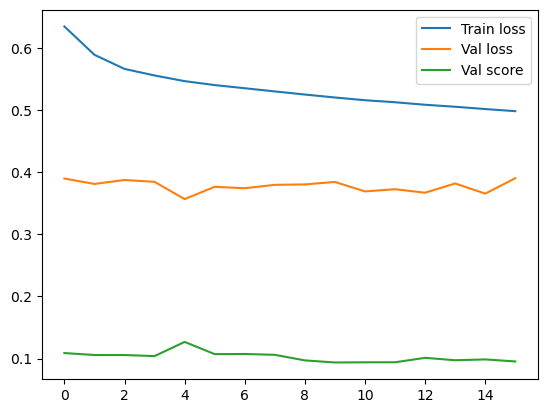

In [94]:
%%time
#num_epochs_per_turn = 20
#num_turns = 5
#eval_freq = 5
train_log = []

if not cfg.load_model_from_file:
    for i in range(cfg.num_turns):
        print('Big epoch', i)
        model, optimizer = train_model(model, optimizer, ds_both_train, ds_defog_valid, eval_freq = cfg.eval_freq, num_epochs = cfg.num_epochs_per_turn)
        #model, optimizer = train_model(model, optimizer, ds_full, ds_valid, eval_freq = cfg.eval_freq, num_epochs = cfg.num_epochs_per_turn)        
        
    pd.DataFrame(train_log, columns=('Train loss', 'Val loss', 'Val score')).plot()

In [74]:
#model.load_state_dict(torch.load("best_model_state.h5", map_location=torch.device(cfg.device)))

In [75]:
#np.array(train_log)
#.to('cpu').numpy()
#for log in train_log:
#    log[3] = log[3].cpu().numpy()

In [76]:
#pd.DataFrame(train_log).plot(x='Epoch')
#torch.save(model.state_dict(), "model_state_02.h5")

In [77]:
#cfg.model_file
#cfg.model_file = 'best_model_state_02.h5'

In [78]:
#if cfg.load_model_from_file:
#    model = FOGModel()
#    model.load_state_dict(torch.load(cfg.model_file, map_location=torch.device(cfg.device)))
#    model.to(cfg.device)
#    model.eval()

In [79]:
sample_submission = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/sample_submission.csv")
sample_submission_defog = sample_submission

In [80]:
test_folder_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/'
test_files = [file for file in os.listdir(test_folder_path)]
test_folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/'
test_files_defog = [file for file in os.listdir(test_folder_path_defog)]

In [81]:
result_defog = pd.DataFrame()

for test_file in test_files_defog:
    print(test_file)
    test_df_defog = pd.read_csv(test_folder_path_defog + test_file) 
    test_df_defog.columns = [camel_to_snake(c) for c in test_df_defog.columns]
    
    test_df_defog[['acc_v', 'acc_ap', 'acc_ml']] = test_df_defog[['acc_v', 'acc_ap', 'acc_ml']]
    
    
    test_df_new = make_features(test_df_defog, defog=True)
    #df_tdcsfog['id'] = df_tdcsfog['id'].apply(lambda x: x.rsplit('.',1)[0])
    test_file_id = test_file.rsplit('.',1)[0]
    pred_new = predict_file(model, test_df_new).reshape(-1,cfg.nlabels+1)
    #pred = np
    pred = rescale_freq_2(pred_new, old_freq = 128, new_freq = 100)
    id_time = [f'{test_file_id}_{t}' for t in test_df_defog['time']]
    tmp = pd.DataFrame(pred[:,:cfg.nlabels], index=id_time)#.loc[[t != -1 for t in time]]
    result_defog = pd.concat([result_defog, tmp])
        
result_defog.columns = ['StartHesitation', 'Turn', 'Walking'][:cfg.nlabels]

02ab235146.csv


In [82]:
result = pd.DataFrame()
for test_file in test_files:
    test_df = pd.read_csv(test_folder_path + test_file) 
    test_df.columns = [camel_to_snake(c) for c in test_df.columns]
    test_df = make_features(test_df)
    #df_tdcsfog['id'] = df_tdcsfog['id'].apply(lambda x: x.rsplit('.',1)[0])
    test_file_id = test_file.rsplit('.',1)[0]
    pred = predict_file(model, test_df).reshape(-1,cfg.nlabels+1)
    #pred = np
    id_time = [f'{test_file_id}_{t}' for t in test_df['time']]
    tmp = pd.DataFrame(pred[:,:cfg.nlabels], index=id_time)#.loc[[t != -1 for t in time]]
    result = pd.concat([result, tmp])
        
result.columns = ['StartHesitation', 'Turn', 'Walking'][:cfg.nlabels]

In [83]:
sample_submission = sample_submission.set_index('Id')
sample_submission.update(result_defog)
sample_submission.update(result)

In [84]:
sample_submission.reset_index().to_csv('submission.csv', index=False)

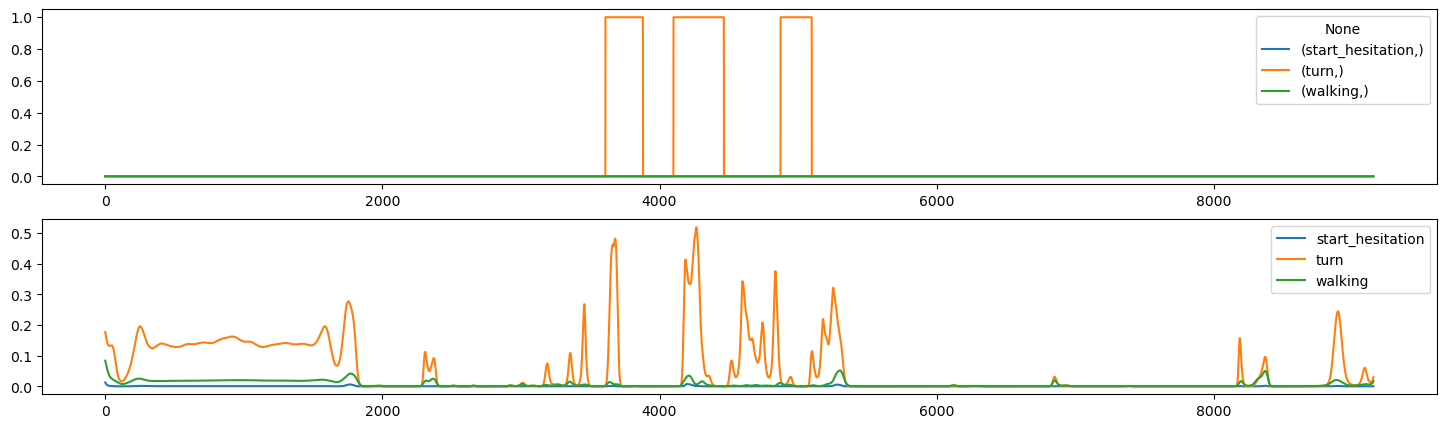

In [85]:
plot_validation_graph(3, model)
#print()

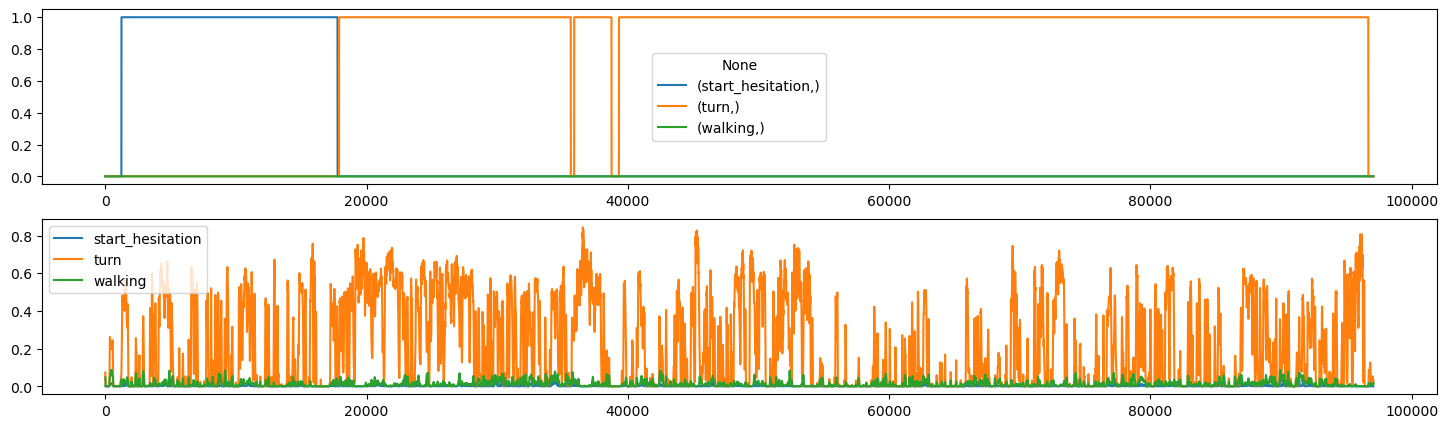

In [86]:
plot_validation_graph(7, model)

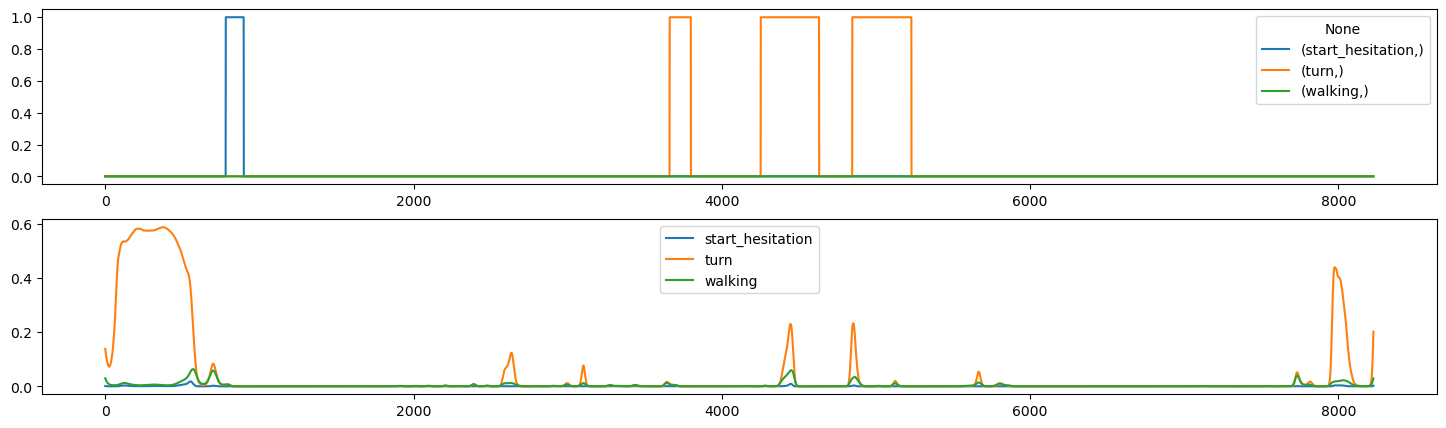

In [87]:
plot_validation_graph(19, model)

In [88]:
#indices = df_tdcsfog[df_tdcsfog['fog']>0].index
#ugly_ids = valid_ids[ valid_ids.index.isin(indices)]
#ugly_ids.iloc[0]

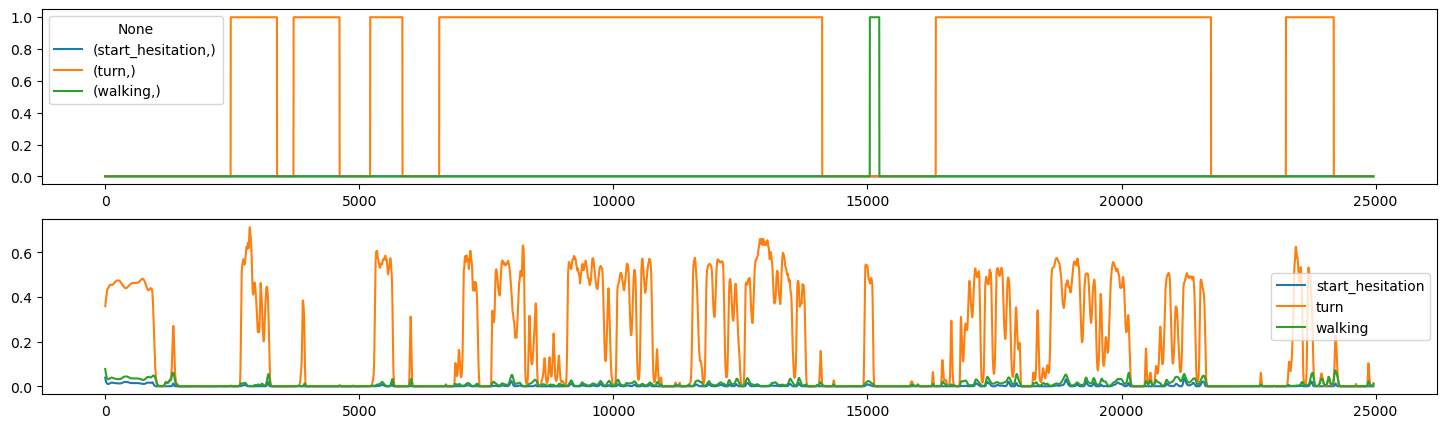

In [89]:
plot_validation_graph(20, model)

In [90]:
#os.listdir('/kaggle/working/')
#os.listdir('/features')

<Axes: >

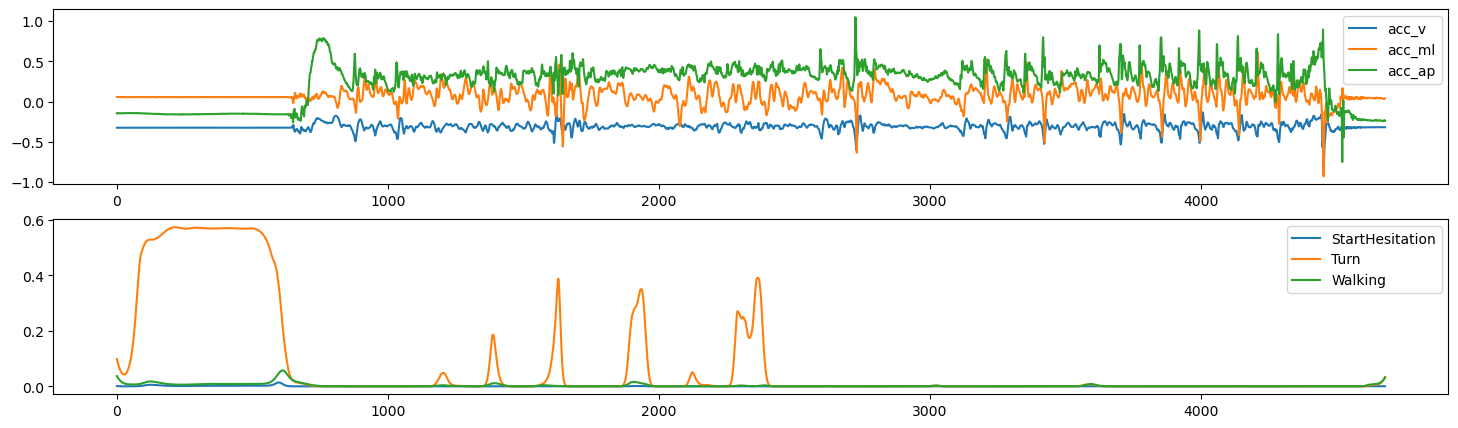

In [91]:
figs, ax = plt.subplots(2,1, figsize=(18,5))
test_df[['acc_v','acc_ml','acc_ap']].plot(ax=ax[0])
sample_submission[:len(test_df)].reset_index(drop=True).plot(ax=ax[1])

<Axes: >

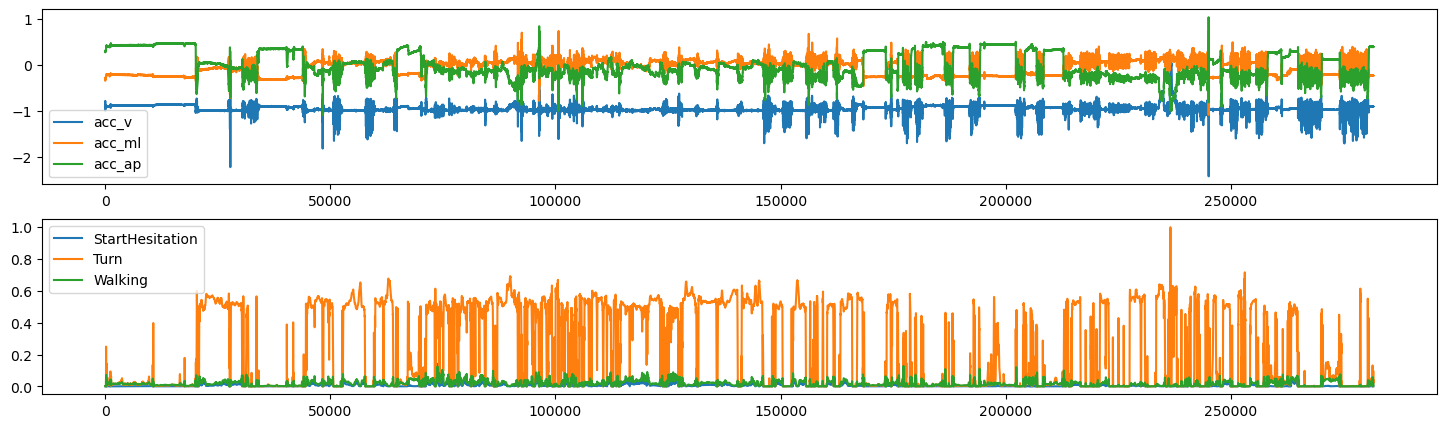

In [92]:
figs, ax = plt.subplots(2,1, figsize=(18,5))
test_df_defog[['acc_v','acc_ml','acc_ap']].plot(ax=ax[0])
sample_submission[len(test_df):len(test_df_defog)+len(test_df)].reset_index(drop=True).plot(ax=ax[1])

In [93]:
#x_slice = x[:, cfg.window_front:cfg.window_front+cfg.window_body ,:]
#x_slice.shape